# Export/Import assets with `ibm-watsonx-ai`

This notebook demonstrates an example for exporting/importing assets using Watson Machine Learning service. It contains steps and code to work with [ibm-watsonx-ai](https://pypi.python.org/pypi/ibm-watsonx-ai) library available in PyPI repository.

## Learning goals

The learning goals of this notebook are:

-  Download an externally trained Keras model.
-  Persist an external model in Watson Machine Learning repository.
-  Export the model from the space
-  Import the model to another space( For Cloud Pak for Data 5.0, the space/project where assets are imported has to be empty ) and deploy



## Contents

This notebook contains the following parts:

1. [Setup](#setup)
2. [Download externally created Keras model](#download)
3. [Persist externally created Keras model](#persistence)
4. [Export the model](#export)
5. [Import the model](#import)
6. [Deploy and score the imported model](#scoring)
7. [Clean up](#cleanup)
8. [Summary and next steps](#summary)

<a id="setup"></a>
## 1. Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Contact with your Cloud Pack for Data administrator and ask him for your account credentials

### Install and import the `ibm-watsonx-ai` and dependecies
**Note:** `ibm-watsonx-ai` documentation can be found <a href="https://ibm.github.io/watsonx-ai-python-sdk/index.html" target="_blank" rel="noopener no referrer">here</a>.

In [ ]:
!pip install wget | tail -n 1
!pip install matplotlib | tail -n 1
!pip install -U ibm-watsonx-ai | tail -n 1

### Connection to WML

Authenticate the Watson Machine Learning service on IBM Cloud Pack for Data. You need to provide platform `url`, your `username` and `api_key`.

In [ ]:
username = 'PASTE YOUR USERNAME HERE'
api_key = 'PASTE YOUR API_KEY HERE'
url = 'PASTE THE PLATFORM URL HERE'

In [1]:
from ibm_watsonx_ai import Credentials

credentials = Credentials(
    username=username,
    api_key=api_key,
    url=url,
    instance_id="openshift",
    version="5.0"
)

Alternatively you can use `username` and `password` to authenticate WML services.

```python
credentials = Credentials(
    username=***,
    password=***,
    url=***,
    instance_id="openshift",
    version="5.0"
)

```

In [2]:
from ibm_watsonx_ai import APIClient

client = APIClient(credentials)

### Create two spaces. One for export and one for import

**Tip**: You can refer to example for space management apis [here](https://github.com/IBM/watson-machine-learning-samples/blob/master/cpd5.0/notebooks/python_sdk/instance-management/Space%20management.ipynb).


In [3]:
import uuid

space_name = str(uuid.uuid4())

export_space_metadata = {
              client.spaces.ConfigurationMetaNames.NAME: 'client_space_export_' + space_name,
              client.spaces.ConfigurationMetaNames.DESCRIPTION: space_name + ' description'
}

space = client.spaces.store(meta_props=export_space_metadata)

export_space_id = client.spaces.get_id(space)
print("{}export space_id: {}{}".format('\n', export_space_id, '\n'))


import_space_metadata = {
              client.spaces.ConfigurationMetaNames.NAME: 'client_space_import_' + space_name,
              client.spaces.ConfigurationMetaNames.DESCRIPTION: space_name + ' description'
}

space = client.spaces.store(meta_props=import_space_metadata)

import_space_id = client.spaces.get_id(space)
print("{}import space_id: {}".format('\n', import_space_id))

Space has been created. However some background setup activities might still be on-going. Check for 'status' field in the response. It has to show 'active' before space can be used. If it's not 'active', you can monitor the state with a call to spaces.get_details(space_id). Alternatively, use background_mode=False when calling client.spaces.store().

export space_id: 069cbdc0-7d79-4e13-9792-03f568c57041

Space has been created. However some background setup activities might still be on-going. Check for 'status' field in the response. It has to show 'active' before space can be used. If it's not 'active', you can monitor the state with a call to spaces.get_details(space_id). Alternatively, use background_mode=False when calling client.spaces.store().

import space_id: 4bf6e043-eefa-42b5-a02e-4459ab11f0e4


<a id="download"></a>
## 2. Download externally created Keras model and data
In this section, you will download externally created Keras models and data used for training it.

In [4]:
import os
import wget

data_dir = 'MNIST_DATA'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)
    
model_path = os.path.join(data_dir, 'mnist_keras.h5.tgz')
if not os.path.isfile(model_path):
    wget.download("https://github.com/IBM/watson-machine-learning-samples/raw/master/cpd5.0/models/keras/mnist_keras.h5.tgz", out=data_dir)

In [5]:
data_dir = 'MNIST_DATA'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)
    
filename = os.path.join(data_dir, 'mnist.npz')
if not os.path.isfile(filename):
    wget.download('https://s3.amazonaws.com/img-datasets/mnist.npz', out=data_dir)  

In [6]:
import numpy as np

dataset = np.load(filename)
x_test = dataset['x_test']

<a id="persistence"></a>
## 3. Persist externally created Keras model

In this section, you will learn how to store your model in Watson Machine Learning repository by using the `ibm-watsonx-ai` Client.

### 3.1: Publish model

Define model name, type and software specification needed to deploy model later.

In [7]:
sofware_spec_id = client.software_specifications.get_id_by_name("runtime-24.1-py3.11")

In [8]:
client.set.default_space(export_space_id)

metadata = {
            client.repository.ModelMetaNames.NAME: 'External Keras model',
            client.repository.ModelMetaNames.TYPE: 'tensorflow_2.14',
            client.repository.ModelMetaNames.SOFTWARE_SPEC_ID: sofware_spec_id
}

published_model = client.repository.store_model(
    model=model_path,
    meta_props=metadata)

### 3.2: Get model details

In [9]:
import json

published_model_id = client.repository.get_model_id(published_model)
model_details = client.repository.get_details(published_model_id)
print(json.dumps(model_details, indent=2))

{
  "entity": {
    "hybrid_pipeline_software_specs": [],
    "software_spec": {
      "id": "45f12dfe-aa78-5b8d-9f38-0ee223c47309",
      "name": "runtime-24.1-py3.11"
    },
    "type": "tensorflow_2.14"
  },
  "metadata": {
    "created_at": "2024-04-26T12:20:31.240Z",
    "id": "0f741c27-b5e4-4810-a38a-3e845a5028ac",
    "modified_at": "2024-04-26T12:20:35.731Z",
    "name": "External Keras model",
    "owner": "1000330999",
    "resource_key": "849598fb-905b-4705-9070-5756098b8002",
    "space_id": "069cbdc0-7d79-4e13-9792-03f568c57041"
  },
  "system": {
    "warnings": []
  }
}


### 3.3 Get all models in the space

space_id is automatically picked up from client.set.default_space() api call before

In [ ]:
models_details = client.repository.list_models()

<a id="export"></a>
## 4. Export

In [10]:
help(client.export_assets.start)

Help on method start in module ibm_watsonx_ai.export_assets:

start(meta_props: 'dict[str, str | bool | list]', space_id: 'str | None' = None, project_id: 'str | None' = None) -> 'dict' method of ibm_watsonx_ai.export_assets.Export instance
    Start the export. Either space_id or project_id has to be provided and is mandatory.
    ALL_ASSETS is by default False. No need to provide explicitly unless it has to be set to True.
    Either ALL_ASSETS or ASSET_TYPES or ASSET_IDS has to be given in the meta_props. Only one of these can be
    provided.
    
    In the `meta_props`:
    
    ALL_ASSETS is a boolean. When set to True, it exports all assets in the given space.
    ASSET_IDS is an array containing the list of assets ids to be exported.
    ASSET_TYPES is for providing the asset types to be exported. All assets of that asset type will be exported.
    
            Eg: wml_model, wml_model_definition, wml_pipeline, wml_function, wml_experiment,
            software_specification, 

client.export_assets has these apis. For any help on these apis, type 'help(api_name)' in your notebook 
Example: help(client.export_assets.start), help(client.export_assets.get_details)

1. client.export_assets.start: This starts the export job. export job is asynchronously executed
2. client.export_assets.get_details: Given export_id and corresponding space_id/project_id, this gives the export job details. Usually used for monitoring the export job submitted with start api
3. client.export_assets.list: Prints summary of all the export jobs
4. client.export_assets.get_exported_content: Downloads the exported content. This information will be used by the import process
5. client.export_assets.delete: Deletes the given export job
6. client.export_assets.cancel: Cancels the given export job if running

### 4.1: Start the export process

Start the export process for the model created. Either ASSET_IDS or ASSET_TYPES or ALL_ASSETS can be provided.
If you have more than one model ids, you need to provide them as array like client.export_assets.ConfigurationMetaNames.ASSET_IDS: [model_id1, model_id2]
Refer to the help api above to see different usages and details

In [25]:
metadata = { client.export_assets.ConfigurationMetaNames.NAME: "export_model",
             client.export_assets.ConfigurationMetaNames.ASSET_IDS: [published_model_id]                                                                         
           }

details = client.export_assets.start(meta_props=metadata, space_id=export_space_id)
print(json.dumps(details, indent=2))

export_job_id = details[u'metadata'][u'id']

export job with id 1b6038ce-71c1-4b64-82e7-d9ed7b3ff2f0 has started. Monitor status using client.export_assets.get_details api. Check 'help(client.export_assets.get_details)' for details on the api usage
{
  "entity": {
    "assets": {
      "all_assets": false,
      "asset_ids": [
        "0f741c27-b5e4-4810-a38a-3e845a5028ac"
      ]
    },
    "format": "json",
    "status": {
      "state": "pending"
    }
  },
  "metadata": {
    "created_at": "2024-04-26T12:27:40.680Z",
    "creator_id": "1000330999",
    "id": "1b6038ce-71c1-4b64-82e7-d9ed7b3ff2f0",
    "name": "export_model",
    "space_id": "069cbdc0-7d79-4e13-9792-03f568c57041",
    "url": "/v2/asset_exports/1b6038ce-71c1-4b64-82e7-d9ed7b3ff2f0"
  }
}


### 4.2: Monitor the export process

In [26]:
import time

start_time = time.time()
diff_time = start_time - start_time
while True and diff_time < 10 * 60:
    time.sleep(3)
    response = client.export_assets.get_details(export_job_id, space_id=export_space_id)
    state = response[u'entity'][u'status'][u'state']
    print(state)
    if state == 'completed' or state == 'error' or state == 'failed':
        break
    diff_time = time.time() - start_time

print(json.dumps(response, indent=2))

completed
{
  "entity": {
    "assets": {
      "all_assets": false,
      "asset_ids": [
        "0f741c27-b5e4-4810-a38a-3e845a5028ac"
      ]
    },
    "format": "json",
    "status": {
      "state": "completed"
    }
  },
  "metadata": {
    "created_at": "2024-04-26T12:27:40.680Z",
    "creator_id": "1000330999",
    "id": "1b6038ce-71c1-4b64-82e7-d9ed7b3ff2f0",
    "name": "export_model",
    "space_id": "069cbdc0-7d79-4e13-9792-03f568c57041",
    "updated_at": "2024-04-26T12:27:43.887Z",
    "url": "/v2/asset_exports/1b6038ce-71c1-4b64-82e7-d9ed7b3ff2f0"
  }
}


### 4.3: Get the exported content

In [ ]:
export_dir = 'EXPORT_DATA'

if not os.path.isdir(export_dir):
    os.mkdir(export_dir)
    
export_file_name = 'exported_content_' + str(uuid.uuid4()) + '.zip'
    
export_file_path = os.path.join(export_dir, export_file_name)

details = client.export_assets.get_exported_content(export_job_id, 
                                                    space_id = export_space_id, 
                                                    file_path = export_file_path)

print(details)

<a id="import"></a>
## 5. Import

client.import_assets has these apis. For any help on these apis, type 'help(api_name)' in your notebook 
Example: help(client.import_assets.start), help(client.import_assets.get_details)

1. client.import_assets.start: This starts the import job. import job is asynchronously executed
2. client.import_assets.get_details: Given import_id and corresponding space_id/project_id, this gives the import job details. Usually used for monitoring the import job submitted with start api
3. client.import_assets.list: Prints summary of all the import jobs
4. client.import_assets.delete: Deletes the given import job
5. client.import_assets.cancel: Cancels the given import job if running

### 5.1: Start the import process

In [14]:
details = client.import_assets.start(file_path=export_file_path,
                                     space_id=import_space_id)
print(json.dumps(details, indent=2))

import_job_id = details[u'metadata'][u'id']

import job with id d80ac277-8114-4c02-a3ce-30f0c8df3516 has started. Monitor status using client.import_assets.get_details api. Check 'help(client.import_assets.get_details)' for details on the api usage
{
  "entity": {
    "format": "json",
    "status": {
      "state": "pending"
    }
  },
  "metadata": {
    "created_at": "2024-04-26T12:21:46.969Z",
    "creator_id": "1000330999",
    "id": "d80ac277-8114-4c02-a3ce-30f0c8df3516",
    "space_id": "4bf6e043-eefa-42b5-a02e-4459ab11f0e4",
    "url": "/v2/asset_imports/d80ac277-8114-4c02-a3ce-30f0c8df3516"
  }
}


### 5.2: Monitor the import process

In [15]:
import time

start_time = time.time()
diff_time = start_time - start_time
while True and diff_time < 10 * 60:
    time.sleep(3)
    response = client.import_assets.get_details(import_job_id,
                                                space_id=import_space_id)
    state = response[u'entity'][u'status'][u'state']
    print(state)
    if state == 'completed' or state == 'error' or state == 'failed':
         break
    diff_time = time.time() - start_time

print(json.dumps(response, indent=2))

client.set.default_space(import_space_id)

print("{}List of models: {}".format('\n', '\n'))
client.repository.list_models()
details = client.repository.get_model_details()

for obj in details[u'resources']:
    if obj[u'metadata'][u'name'] == "External Keras model":
        model_id_for_deployment = obj[u'metadata'][u'id']

print("{}model id for deployment: {}".format('\n', model_id_for_deployment))

completed
{
  "entity": {
    "format": "json",
    "status": {
      "state": "completed"
    }
  },
  "metadata": {
    "created_at": "2024-04-26T12:21:46.969Z",
    "creator_id": "1000330999",
    "id": "d80ac277-8114-4c02-a3ce-30f0c8df3516",
    "space_id": "4bf6e043-eefa-42b5-a02e-4459ab11f0e4",
    "updated_at": "2024-04-26T12:21:53.383Z",
    "url": "/v2/asset_imports/d80ac277-8114-4c02-a3ce-30f0c8df3516"
  }
}

List of models: 


model id for deployment: 2a79d196-10ee-45e4-9cdf-38f9fd477a24


List the import and export jobs

In [30]:
print("\nImport jobs:")
client.import_assets.list(space_id=import_space_id)


Import jobs:


,ID,CREATED,STATUS
0,d80ac277-8114-4c02-a3ce-30f0c8df3516,2024-04-26T12:21:46.969Z,completed


In [34]:
print("Export jobs: \n")
client.export_assets.list(space_id=export_space_id)

Export jobs: 



,ID,NAME,CREATED,STATUS
0,1b6038ce-71c1-4b64-82e7-d9ed7b3ff2f0,export_model,2024-04-26T12:27:40.680Z,completed


<a id="scoring"></a>
## 6. Deploy and score the imported model

### 6.1: Create model deployment

#### Create online deployment for published model

In [35]:
metadata = {
    client.deployments.ConfigurationMetaNames.NAME: "Deployment of external Keras model",
    client.deployments.ConfigurationMetaNames.ONLINE: {}
}

created_deployment = client.deployments.create(model_id_for_deployment, meta_props=metadata)



######################################################################################

Synchronous deployment creation for id: '2a79d196-10ee-45e4-9cdf-38f9fd477a24' started

######################################################################################


initializing
Note: online_url is deprecated and will be removed in a future release. Use serving_urls instead.
....
ready


-----------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_id='69c0f383-d4fc-4a15-bfbf-789ede04a0ac'
-----------------------------------------------------------------------------------------------




In [36]:
deployment_id = client.deployments.get_id(created_deployment)

Now you can print an online scoring endpoint. 

In [ ]:
scoring_endpoint = client.deployments.get_scoring_href(created_deployment)
print(scoring_endpoint)

You can also list existing deployments.

In [ ]:
client.deployments.list()

### 6.2: Get deployment details

In [ ]:
details = client.deployments.get_details(deployment_id)
print(json.dumps(details, indent=2))

### 6.3: Score

You can use below method to do test scoring request against deployed model.

Let's first visualize two samples from dataset, we'll use for scoring. You must have matplotlib package installed

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt

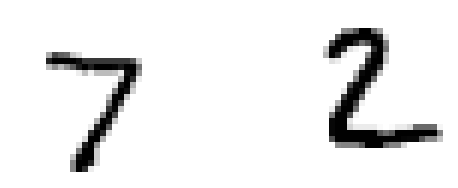

In [40]:
for i, image in enumerate([x_test[0], x_test[1]]):
    plt.subplot(2, 2, i + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')

Prepare scoring payload with records to score.

In [41]:
score_0 = x_test[0].flatten().tolist()
score_1 = x_test[1].flatten().tolist()

In [42]:
scoring_payload = {"input_data": [{"values": [score_0, score_1]}]}

Use ``client.deployments.score()`` method to run scoring.

In [43]:
predictions = client.deployments.score(deployment_id, scoring_payload)

In [44]:
print(json.dumps(predictions, indent=2))

{
  "predictions": [
    {
      "id": "dense_2",
      "fields": [
        "prediction",
        "prediction_classes",
        "probability"
      ],
      "values": [
        [
          [
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            1.0,
            0.0,
            0.0
          ],
          7,
          [
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            1.0,
            0.0,
            0.0
          ]
        ],
        [
          [
            0.0,
            0.0,
            1.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0
          ],
          2,
          [
            0.0,
            0.0,
            1.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0
          ]


<a id="cleanup"></a>
## 7. Clean up 

In [45]:
client.export_assets.delete(export_job_id, space_id=export_space_id)
client.import_assets.delete(import_job_id, space_id=import_space_id)

client.spaces.delete(export_space_id)
client.spaces.delete(import_space_id)

Export job deleted
Import job deleted
DELETED
DELETED


'SUCCESS'

If you want to clean up all created assets:
- experiments
- trainings
- pipelines
- model definitions
- models
- functions
- deployments

please follow up this sample [notebook](https://github.com/IBM/watson-machine-learning-samples/blob/master/cpd5.0/notebooks/python_sdk/instance-management/Machine%20Learning%20artifacts%20management.ipynb).

<a id="summary"></a>
## 8. Summary and next steps

You successfully completed this notebook! You learned how to use export/import assets client apis.

Check out our _<a href="https://ibm.github.io/watsonx-ai-python-sdk/samples.html" target="_blank" rel="noopener no referrer">Online Documentation</a>_ for more samples, tutorials, documentation, how-tos, and blog posts. 

### Authors

*Mithun - *vbmithun@in.ibm.com**, Software Engineer

Copyright © 2020-2025 IBM. This notebook and its source code are released under the terms of the MIT License.